In [57]:
%load_ext autoreload
%autoreload 2
import numpy as np
import openmm as mm
from lean.forces import InductiveRadialUnbiasingForce, GaussianForce
from lean.integrators import NonEquilibriumAnnealedImportanceSamplingOverdampedLangevinIntegrator as Integrator
from lean.integrators import integrate
from lean.parallel import loop_integrate
from lean.loss import action_matching_loss
from lean import unit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
def dw_force(k2=-2.0, k4=0.45, d0=4.0):
    force = mm.CustomBondForce("k2*(r-d0)^2+k4*(r-d0)^4")
    force.addPerBondParameter("k2")
    force.addPerBondParameter("k4")
    force.addPerBondParameter("d0")
    force.setForceGroup(0)
    return force

def dw2():
    system = mm.System()
    force = dw_force()
    k2 = -2.0 * unit.ENERGY / unit.LENGTH**2
    k4 = 0.45 * unit.ENERGY / unit.LENGTH**4
    d0 = 4.0 * unit.LENGTH
    system.addParticle(1.0)
    system.addParticle(1.0)
    force.addBond(0, 1, [k2, k4, d0])
    system.addForce(force)
    return system

def energy_function(x):
    return -2.0 * (x - 4.0)**2 + 0.45 * (x - 4.0)**4

In [59]:
system = dw2()
force = InductiveRadialUnbiasingForce(2)
force.add_force(system)
gaussian_force = GaussianForce(k=1.0*unit.ENERGY/unit.LENGTH**2)
# gaussian_force.add_force(system)

friction = 10.0 / mm.unit.picoseconds
stepsize= 1.0 * mm.unit.femtoseconds
temperature = 300 * mm.unit.kelvin
steps = 10000

integrator = Integrator(
    temperature=temperature,
    friction=friction,
    stepsize=stepsize,
)

# integrator = mm.BrownianIntegrator(
#     temperature,
#     friction,
#     stepsize,
# )

from lean.parallel import loop_integrate

context = mm.Context(system, integrator, mm.Platform.getPlatformByName('Reference'))
context.setPositions(np.random.randn(2, 3) * unit.LENGTH)

x, t, a = loop_integrate(
    n=16,
    force=force,
    system=system,
    context=context,
    integrator=integrator,
    steps=steps,
    num_samples=steps,
    T=1.0,
)
    


In [60]:
from matplotlib import pyplot as plt
import torch
distance = torch.norm(x[:, :, 0, :] - x[:, :, 1, :], dim=-1)

(array([3., 0., 1., 0., 0., 0., 2., 3., 4., 3.]),
 array([2.48881124, 2.8597773 , 3.23074336, 3.60170942, 3.97267548,
        4.34364154, 4.7146076 , 5.08557366, 5.45653973, 5.82750579,
        6.19847185]),
 <BarContainer object of 10 artists>)

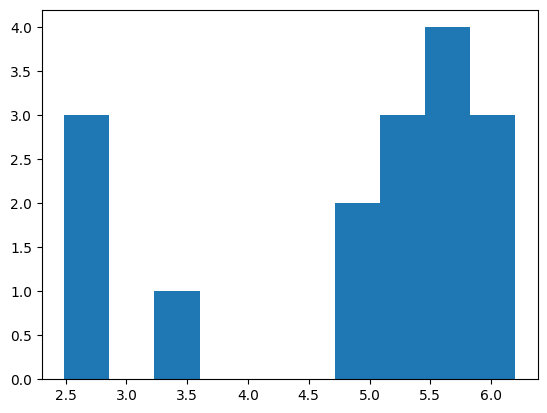

In [61]:
from matplotlib import pyplot as plt
plt.hist(distance[:, -1])

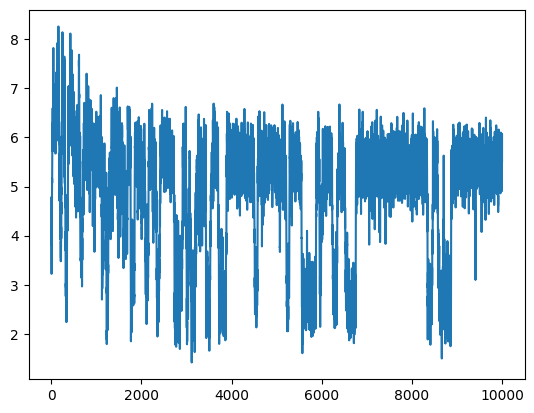

In [62]:
plt.plot(distance[0])